In [ ]:
# # hybrid_kmeans_dbscan.py

# import numpy as np
# import os
# import scipy.io as sio
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D

# # THRESHOLD_VALUE = 1.334
# def load_volume(filepath,THRESHOLD_VALUE):
#     if filepath.endswith('.npy'):
#         volume = np.load(filepath)
#         volume[volume <= THRESHOLD_VALUE] = 0  # Threshold to remove background
#     elif filepath.endswith('.mat'):
#         mat = sio.loadmat(filepath)
#         # Assuming your volume variable is named 'volume' in .mat
#         volume = next(v for v in mat.values() if isinstance(v, np.ndarray) and v.ndim == 3)
#         volume[volume <= THRESHOLD_VALUE] = 0  # Threshold to remove background
#     else:
#         raise ValueError("Unsupported file format. Use .mat or .npy")
#     return volume

# def extract_features(volume):
#     coords = np.array(np.nonzero(volume)).T
#     intensities = volume[volume > 0].flatten().reshape(-1, 1)
#     return np.hstack((coords, intensities))

# def run_kmeans(X_scaled, n_clusters=4):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     return kmeans.fit_predict(X_scaled)

# def run_dbscan_per_cluster(X_scaled, kmeans_labels, eps=0.6, min_samples=5):
#     final_labels = -np.ones(len(X_scaled), dtype=int)
#     label_offset = 0
#     for cluster_id in np.unique(kmeans_labels):
#         indices = np.where(kmeans_labels == cluster_id)[0]
#         db = DBSCAN(eps=eps, min_samples=min_samples)
#         sub_labels = db.fit_predict(X_scaled[indices])
#         sub_labels[sub_labels != -1] += label_offset
#         final_labels[indices] = sub_labels
#         label_offset += sub_labels.max() + 1 if sub_labels.max() != -1 else 0
#     return final_labels

# def save_results(output_dir, labels, coords):
#     os.makedirs(output_dir, exist_ok=True)
#     np.save(os.path.join(output_dir, "cluster_labels.npy"), labels)
#     sio.savemat(os.path.join(output_dir, "cluster_labels.mat"), {"labels": labels})
#     np.save(os.path.join(output_dir, "voxel_coords.npy"), coords)

# def plot_clusters(coords, labels, title="Cluster Visualization"):
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
#     scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=labels, cmap='tab20', s=2)
#     plt.title(title)
#     plt.colorbar(scatter)
#     plt.show()

# # Example use:
# volume = load_volume("yourfile.mat")
# X = extract_features(volume)
# X_scaled = StandardScaler().fit_transform(X)
# kmeans_labels = run_kmeans(X_scaled, n_clusters=4)
# final_labels = run_dbscan_per_cluster(X_scaled, kmeans_labels)
# plot_clusters(X[:, :3], final_labels)
# save_results("output_dir", final_labels, X[:, :3])


I've created a working .py script that:

Lets you load either .mat or .npy files

Applies K-Means followed by DBSCAN

Visualizes clusters using matplotlib in 3D

Saves cluster labels and voxel coordinates to both .npy and .mat formats

Creates an output directory automatically for saved files



 --------------->  check step by step : SRCFILES: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes --> DATAFILES: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData --> 
 listfiles: ['AML2_cell11.npy', 'AML3_cell16.npy', 'grabaje.m', 'Tomogramma_BuddingYeastCell.npy', 'Tomogramma_Cell1.npy', 'Tomogramma_Cell2.npy', 'Tomogramma_Cell3.npy', 'tomo_Grafene_24h.npy', 'tomo_grafene_48h.npy'] 
 --> Datafile random choice: AML2_cell11.npy


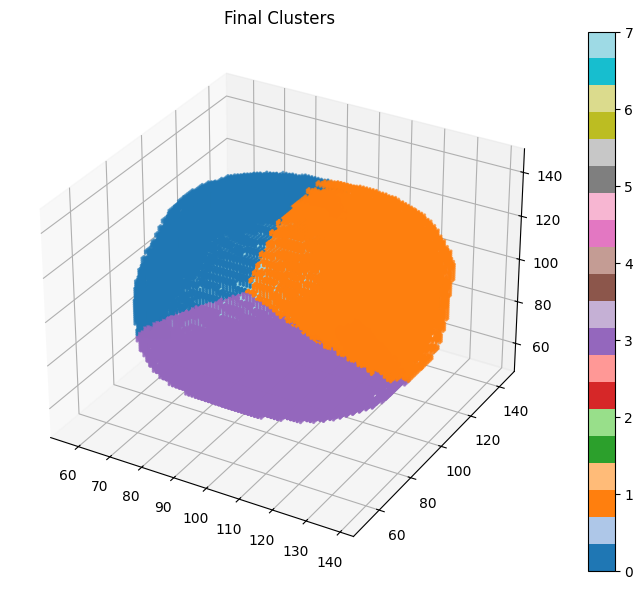

In [2]:
from hybrid_kmeans_dbscan import *
import os 
from pathlib import Path
import random

SRCFILES  = Path.cwd().parent
DATAFILES  = SRCFILES/"data"/"raw_npyData"

listfiles = os.listdir(str(DATAFILES))
Datafile = random.choice(listfiles)

print(f" --------------->  check step by step : SRCFILES: {SRCFILES} --> DATAFILES: {DATAFILES} --> \n listfiles: {listfiles} \n --> Datafile random choice: {Datafile}")
# Datafile = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw\Tomogramma_BuddingYeastCell.mat"
FileCompletePath = os.path.join(DATAFILES,Datafile)
THRESHOLD_VALUE = 1.334
volume = load_volume(FileCompletePath,THRESHOLD_VALUE)  # or .npy

X = extract_features(volume)

X_scaled = StandardScaler().fit_transform(X)

kmeans_labels = run_kmeans(X_scaled, n_clusters=4)
final_labels = run_dbscan_per_cluster(X_scaled, kmeans_labels, eps=0.6, min_samples=100)

plot_clusters(X[:, :3], final_labels, title="Final Clusters")
save_results("clustering_output", final_labels, X[:, :3])


In [1]:
# import numpy as np
# Adjust parsing to handle np.float64(...) formatting using regular expressions
import re
import os
from pathlib import Path
import pandas as pd
import ast

# Reload the file after execution reset
# txt_path = 'results\featureQuantileThres\AllFeatures_Stats.txt'
# import os

txt_path = r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\results\featureQuantileThres\AllFeatures_Stats.txt"
txt_path = os.path.normpath(txt_path)
print(f"txt_path: {txt_path}")

rows = []

with open(txt_path, 'r') as file:
    for line in file:
        if ':' in line:
            name, data_str = line.split(':', 1)
            # Replace np.float64(...) with float values using regex
            cleaned_data_str = re.sub(r'np\.float64\((.*?)\)', r'\1', data_str.strip())
            data_dict = ast.literal_eval(cleaned_data_str)
            data_dict = {k: float(v) for k, v in data_dict.items()}
            data_dict['Filename'] = name.strip()
            rows.append(data_dict)

# Convert to DataFrame
df = pd.DataFrame(rows)

# Reorder columns to start with Filename
cols = ['Filename'] + [col for col in df.columns if col != 'Filename']
df = df[cols]

# Save as CSV
BASE_DIR = Path.cwd().parent
csv_path = BASE_DIR/ "results"/ "featureQuantileThres"

csv_file = "AllFeatures_Stats_Converted.csv" # Save CSV locally
csv_path = os.path.join(csv_path,csv_file)

# df.to_csv("AllFeatures_Stats_Converted.csv", index=False)
df.to_csv(csv_path, index=False)

print("CSV file saved as AllFeatures_Stats_Converted.csv")



txt_path: E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\results\featureQuantileThres\AllFeatures_Stats.txt


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Projects\\substructure_3d_data\\Substructure_Different_DataTypes\\results\\featureQuantileThres\\AllFeatures_Stats.txt'

In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from pathlib import Path
import os

def create_mesh_from_mask(data, mask, title="Mesh", transparency=0.3):
    if not np.any(mask):
        print(f"⚠️ No points in {title}. Skipping visualization.")
        return

    try:
        verts, faces, _, _ = marching_cubes(data * mask, level=0)
    except Exception as e:
        print(f"⚠️ Mesh creation failed for {title}: {e}")
        return

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.4, 0.6, 1.0])
    mesh = mesh.filter_smooth_simple(number_of_iterations=1)

    app = o3d.visualization.gui.Application.instance
    app.initialize()
    window = app.create_window(title, 1024, 768)
    scene = o3d.visualization.rendering.Open3DScene(window.renderer)

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLitTransparency"
    mat.base_color = [0.4, 0.6, 1.0, transparency]
    mat.base_roughness = 0.5

    scene.add_geometry("mesh", mesh, mat)
    bbox = mesh.get_axis_aligned_bounding_box()
    
    center = bbox.get_center()
    eye = center + np.array([0, 0, -1])  # Convert to NumPy array
    up = [0, -1, 0]

    scene.scene.camera.look_at(center, eye, up)

    # scene.scene.camera.look_at(
    # bbox.get_center(),           # center
    # bbox.get_center() + [0, 0, -1],  # eye position
    # [0, -1, 0]                   # up vector
    # )

    # scene.setup_camera(60, bbox, bbox.get_center())

    def on_layout(context):
        r = window.content_rect
        scene.scene.set_viewport(r)

    window.set_on_layout(on_layout)
    app.run()

def threshold_and_visualize(npy_file_path, threshold_val=1.20148978654012):
    print(f"CAN SEE THE NPYPATH : {npy_file_path}")
    # data = np.load(str(npy_file_path))
    data = np.load(npy_file_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D numpy array.")

    print(f"📁 Loaded: {npy_file_path.name} with shape {data.shape}")
    
    mask_lower = data <= threshold_val
    mask_upper = data > threshold_val

    # create_mesh_from_mask(data, mask_lower, title="Lower Threshold Mesh", transparency=0.1)
    create_mesh_from_mask(data, mask_upper, title="Upper Threshold Mesh", transparency=0.2)


# ====== Replace this with your actual .npy file path ======
# import os

# filepath = r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\data\raw_npyData"
# npy_path = os.path.join(filepath,'tomo_Grafene_24h.npy')
# # npy_path = Path("path/to/your/datafile.npy")  # 🛠️ Replace this path
# threshold_and_visualize(npy_path, threshold_val=1.44148978654012)


In [ ]:
from pathlib import Path

# Safe path definition
filepath = Path(r"E:/Projects/substructure_3d_data/Substructure_Different_DataTypes/data/raw_npyData")
npy_path = filepath / "tomo_Grafene_24h.npy"

threshold_and_visualize(npy_path, threshold_val=1.201978654012)


In [2]:
import numpy as np
thres = 5
array = np.random.randint(0,10,size=(5,5,5))
print(array)
data = array > thres
print(f"\n data --> {thres} --> \n {data} \n")

[[[3 6 7 3 5]
  [4 7 4 8 8]
  [5 1 3 8 8]
  [8 9 7 5 4]
  [3 6 5 0 0]]

 [[1 4 5 8 5]
  [3 3 9 3 7]
  [9 9 4 7 1]
  [5 7 4 1 6]
  [6 3 4 2 5]]

 [[6 0 5 4 7]
  [4 6 1 5 6]
  [6 5 6 0 0]
  [0 9 8 1 7]
  [7 3 6 4 2]]

 [[5 6 1 3 5]
  [1 0 4 1 3]
  [5 8 5 4 1]
  [0 0 6 0 3]
  [4 7 6 7 4]]

 [[5 6 8 7 3]
  [8 8 2 0 7]
  [4 8 6 7 6]
  [5 9 9 9 4]
  [4 9 9 2 2]]]

 data --> 5 --> 
 [[[False  True  True False False]
  [False  True False  True  True]
  [False False False  True  True]
  [ True  True  True False False]
  [False  True False False False]]

 [[False False False  True False]
  [False False  True False  True]
  [ True  True False  True False]
  [False  True False False  True]
  [ True False False False False]]

 [[ True False False False  True]
  [False  True False False  True]
  [ True False  True False False]
  [False  True  True False  True]
  [ True False  True False False]]

 [[False  True False False False]
  [False False False False False]
  [False  True False False False]
  [

In [ ]:
# data

In [3]:
import numpy as np
thres = 0.5
array = np.random.rand(2,2,2)
print(array)
data = array > thres
print(f"\n data --> {thres} --> \n {data} \n")
array = array
print(f"arraysize:{array.shape} \n and \n {array} \n " )

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from scipy.io import loadmat  # For .mat support
# volume = np.load('data')
verts,faces,_, _ = marching_cubes(data,level=0)
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.6, 0.2, 1.0])

# Visualize
o3d.visualization.draw_geometries([mesh])

[[[0.29207134 0.47366561]
  [0.7560084  0.46925675]]

 [[0.84632481 0.29932125]
  [0.1065663  0.08978314]]]

 data --> 0.5 --> 
 [[[False False]
  [ True False]]

 [[ True False]
  [False False]]] 

arraysize:(2, 2, 2) 
 and 
 [[[0.29207134 0.47366561]
  [0.7560084  0.46925675]]

 [[0.84632481 0.29932125]
  [0.1065663  0.08978314]]] 
 
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes

# Simulated 3D data (a sphere)
# x, y, z = np.indices((100, 100, 100))
# sphere = (x - 50)**2 + (y - 50)**2 + (z - 50)**2
# volume = np.exp(-sphere / 500)  # Smooth decay
data = np.zeros((2, 3, 3))
data[1, 1, 1] = 1.0 
# data[1, 1, 2] = 1.5 
# data[1, 2, 2] = 1.8

print(data)
# Threshold
# threshold = 0.5
# binary = volume > threshold

# Mesh
# verts, faces, _, _ = marching_cubes(volume * binary, level=0)
verts, faces, _, _ = marching_cubes(data, level=0)
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.6, 0.2, 1.0])

# Visualize
o3d.visualization.draw_geometries([mesh])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]]


In [ ]:
verts

In [ ]:
faces

In [5]:
# this is workin fine even if large data size is there. make a function or class of it , and use it when required.

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be 3D"
    return data

def create_mesh_from_volume(volume, simplify=True):
    # Automatically find threshold using Otsu’s method
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold used: {threshold:.4f}")

    # Marching cubes
    print("[INFO] Extracting mesh using marching cubes...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Original mesh: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    if simplify:
        voxel_size = max(volume.shape) / 64  # Tweakable
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Simplified mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    mesh.paint_uniform_color([0.6, 0.7, 1.0])
    return mesh

def visualize_mesh(mesh):
#     o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=False)

# ========== 🧪 Example ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, simplify=True)
# visualize_mesh(mesh)
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
for filename  in os.listdir(input_npy):
    if filename.endswith('.npy'):

        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
    #     input_npy = input_npy/"tomo_Grafene_24h.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    #     volume = load_data(input_npy)
        volume = load_data(str(npyfilePath))
        mesh = create_mesh_from_volume(volume, simplify=True)
        visualize_mesh(mesh)

c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes
filename in the path : AML2_cell11.npy
[INFO] Otsu Threshold used: 1.3439
[INFO] Extracting mesh using marching cubes...
[INFO] Original mesh: 32859 vertices, 65678 faces
[INFO] Simplified mesh: 2917 vertices, 5927 faces
filename in the path : AML3_cell16.npy
[INFO] Otsu Threshold used: 1.3487
[INFO] Extracting mesh using marching cubes...
[INFO] Original mesh: 30706 vertices, 61392 faces
[INFO] Simplified mesh: 2672 vertices, 5439 faces
filename in the path : Tomogramma_BuddingYeastCell.npy
[INFO] Otsu Threshold used: 1.3574
[INFO] Extracting mesh using marching cubes...
[INFO] Original mesh: 19460 vertices, 38908 faces
[INFO] Simplified mesh: 1740 vertices, 3483 faces
filename in the path : Tomogramma_Cell1.npy
[INFO] Otsu Threshold used: 1.3557
[INFO] Extracting mesh using marching cubes...
[INFO] Original mesh: 24013 vertices, 48018 faces
[INFO] Simplified mesh: 2072 vertices, 4237 faces
filen

In [ ]:
print(os.listdir(npy_path))

In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=128, simplify=True, color_mode='gradient'):
    """
        Enhancements:
        Control grid resolution using grid_factor (affects voxel_size for simplification).
        Color grading based on vertex Z-values (color_mode='gradient') or keep uniform (color_mode='uniform').
        Clear toggles for both via function parameters.
    """
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        colors = np.stack([norm_z, 0.6 * np.ones_like(norm_z), 1.0 - norm_z], axis=1)
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

def visualize_mesh(mesh):
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# ========== 🧪 Example Usage ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient')
# visualize_mesh(mesh)


In [ ]:
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
for filename  in os.listdir(input_npy):
    if filename.endswith('.npy'):

        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
    #     input_npy = input_npy/"tomo_Grafene_24h.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    #     volume = load_data(input_npy)
        volume = load_data(str(npyfilePath))
        mesh = create_mesh_from_volume(volume, grid_factor=256, simplify=True, color_mode='gradient')
        visualize_mesh(mesh)

In [ ]:
#  improvement using d solution , 

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient'):
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        # Enhanced color gradient (red to green to blue)
        colors = np.zeros((len(norm_z), 3))
        colors[:, 0] = 1.0 - norm_z  # Red decreases with Z
        colors[:, 1] = norm_z        # Green increases with Z
        colors[:, 2] = norm_z        # Blue increases with Z
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

def visualize_mesh(mesh, transparency=0.5):
    # Create visualizer with material properties
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    # Add mesh with material properties
    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLit"
    
    # Modern Open3D versions use base_alpha instead of transparency
        # Handle version compatibility
    if hasattr(mat, 'transparency'):
        mat.transparency = transparency
    else:
        mat.base_alpha = 1.0 - transparency
    # mat.base_alpha = 1.0 - transparency  # Alpha is inverse of transparency
    
    # Additional material properties for better visualization
    mat.base_roughness = 0.4
    mat.base_metallic = 0.0
    mat.base_color = [1.0, 1.0, 1.0, 1.0]  # RGBA
    
    vis.add_geometry(mesh, material=mat)
    
    # Configure render options
    render_opt = vis.get_render_option()
    render_opt.mesh_show_back_face = True
    render_opt.mesh_show_wireframe = False
    render_opt.light_on = True
    render_opt.background_color = np.asarray([1.0, 1.0, 1.0])
    render_opt.mesh_show_transparency = True  # Critical for transparency
    
    # Run visualization
    vis.run()
    vis.destroy_window()

# ========== Example Usage ========== #
# npy_path = "path_to_your_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient')
# visualize_mesh(mesh, transparency=0.6)

# ========== Example Usage ========== #
# npy_path = "path_to_your_data.npy"
# volume = load_data(npy_path)
# Create mesh with 60% transparency
# mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, 
#                               color_mode='gradient', transparency=0.6)
# visualize_mesh(mesh)

    
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
npy_path = PROJECT_PATH/"data"/"raw_npyData"
datafile = npy_path/"tomo_Grafene_24h.npy"
volume = load_data(str(datafile))
# Create mesh first (without transparency)
mesh = create_mesh_from_volume(volume, grid_factor=64, color_mode='gradient')

# Then visualize with transparency
transparency=0.6
base_alpha = 1.0 - transparency 
# visualize_mesh(mesh, transparency=0.6)  # 60% transparent
visualize_mesh(mesh, base_alpha)  # 60% transparent

# mesh, alpha = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient', transparency=0.2)
# visualize_mesh_with_transparency(mesh, transparency=alpha)

c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes
[INFO] Otsu Threshold: 1.4310
[INFO] Extracting mesh...
[INFO] Mesh before simplification: 251416 vertices, 502816 faces
[INFO] Mesh after simplification: 10796 vertices, 21713 faces


AttributeError: 'open3d.cpu.pybind.visualization.rendering.MaterialRecord' object has no attribute 'base_alpha'

: 

In [1]:
import open3d as o3d;
# print(f"this is version of o3d: {o3d.__version__}")
print(o3d.__version__)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0.19.0


In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=128, simplify=True, color_mode='gradient'):
    """
        Enhancements:
        Control grid resolution using grid_factor (affects voxel_size for simplification).
        Color grading based on vertex Z-values (color_mode='gradient') or keep uniform (color_mode='uniform').
        Clear toggles for both via function parameters.
    """
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        colors = np.stack([norm_z, 0.6 * np.ones_like(norm_z), 1.0 - norm_z], axis=1)
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

# def visualize_mesh(mesh):
#     o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# ========== 🧪 Example Usage ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient')
# visualize_mesh(mesh)

def visualize_mesh(mesh, transparency=0.5):
    mesh.compute_vertex_normals()

    # Convert to TriangleMeshModel for transparency
    mesh.material = o3d.visualization.rendering.MaterialRecord()
    mesh.material.shader = "defaultLitTransparency"
    mesh.material.base_color = [1.0, 0.6, 1.0, transparency]  # RGBA
    vis.get_render_option().background_color = np.array([0, 0, 0])  # black background

    vis = o3d.visualization.O3DVisualizer("Transparent Mesh Viewer", 1024, 768)
    vis.add_geometry("Mesh", mesh, mesh.material)
    vis.reset_camera_to_default()
    vis.show()


In [ ]:
# npy_path = "path/to/your/3ddata.npy"
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
npy_path = PROJECT_PATH/"data"/"raw_npyData"
datafile = npy_path/"tomo_Grafene_24h.npy"
volume = load_data(str(datafile))
mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient')
visualize_mesh(mesh, transparency=0.4)


In [ ]:
# import numpy as np
# data = range(11)
# data = list(data)
# print(data)
# quartileData= np.quantile(data,0.50)
# print(quartileData)
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)

npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
resultData = PROJECT_PATH/"results"


In [ ]:
import numpy as np
from skimage.filters import threshold_otsu
import plotly.express as px
import os

def visualize_ostu(extract_data,npy_path):
    # Extract coordinates of foreground for plotting
    foreground_mask = extract_data
    coords = np.argwhere(foreground_mask)
    coords = coords[np.random.choice(len(coords), size=min(len(coords), 50000), replace=False)]

    # Plot
    fig = px.scatter_3d(
        x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
        opacity=0.008,
        title=f"Foreground Voxel Visualization ({os.path.basename(npy_path)})",
        labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
    )
    fig.show()

def apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
    output_dir = os.path.join(resultDataPath,output_dir)
    os.makedirs(output_dir, exist_ok=True)

    extractedFilename = os.path.basename(npy_path) # return the filename as string.
    # Load the 3D data
    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    # Apply Otsu threshold
    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    print(f"Otsu Threshold: {threshold:.3f}")

    # Create masks
    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    # Save masks
    np.save(os.path.join(output_dir, f"fgnd_mask{extractedFilename}.npy"), foreground_mask)
    np.save(os.path.join(output_dir, f"bgnd_mask{extractedFilename}.npy"), background_mask)

    # # Extract coordinates of foreground for plotting
    # coords = np.argwhere(foreground_mask)
    # coords = coords[np.random.choice(len(coords), size=min(len(coords), 50000), replace=False)]

    # # Plot
    # fig = px.scatter_3d(
    #     x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
    #     opacity=0.5,
    #     title=f"Foreground Voxel Visualization ({os.path.basename(npy_path)})",
    #     labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
    # )
    # fig.show()

    return threshold, foreground_mask, background_mask

# === Example usage ===
if __name__ == "__main__":

    from pathlib import Path
    import os

    PROJECT_PATH = Path.cwd().parent
    # PROJECT_PATH = Path(__file__).resolve().parent.parent
    print(PROJECT_PATH)
    resultData = PROJECT_PATH/"results"
    npy_path = PROJECT_PATH/"data"/"raw_npyData"
    # npy_path = PROJECT_PATH/"data"/"normalized_npyData"
    input_npy = npy_path  # <-- Replace with your actual file path
    # input_npy = os.listdir(input_npy)
    for filename  in os.listdir(input_npy):
        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"

        res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
        visualize_ostu(res[1],npyfilePath)
        visualize_ostu(res[2],npyfilePath)



In [ ]:
# Re-import necessary packages after kernel reset
import numpy as np
import os
from skimage.filters import threshold_otsu
import plotly.graph_objects as go
import plotly.express as px

def apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
    output_dir = os.path.join(resultDataPath, output_dir)
    os.makedirs(output_dir, exist_ok=True)

    extractedFilename = os.path.basename(npy_path)
    data = np.load(npy_path)

    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    np.save(os.path.join(output_dir, f"{extractedFilename}_fg_mask.npy"), foreground_mask)
    np.save(os.path.join(output_dir, f"{extractedFilename}_bg_mask.npy"), background_mask)

    return threshold, foreground_mask, background_mask


def visualize_foreground_background(fg_mask, bg_mask, title="3D Otsu Segmentation", use_mesh=False, downsample=True, max_points=50000):
    fg_coords = np.argwhere(fg_mask)
    bg_coords = np.argwhere(bg_mask)

    if downsample:
        if len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        if len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]

    if not use_mesh:
        fig = px.scatter_3d(
            x=fg_coords[:, 0], y=fg_coords[:, 1], z=fg_coords[:, 2],
            color=fg_coords[:, 2],
            opacity=0.08,
            color_continuous_scale="Blues",
            title=f"{title} - Foreground",
            labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
        )
        fig.add_trace(go.Scatter3d(
            x=bg_coords[:, 0], y=bg_coords[:, 1], z=bg_coords[:, 2],
            mode='markers',
            marker=dict(size=1, opacity=0.01, color='gray'),
            name='Background'
        ))
    else:
        fig = go.Figure()

        fig.add_trace(go.Mesh3d(
            x=fg_coords[:, 0], y=fg_coords[:, 1], z=fg_coords[:, 2],
            alphahull=5,
            opacity=0.15,
            color='lightblue',
            name='Foreground (Mesh)'
        ))
        # fig.add_trace(go.Mesh3d(
        #     x=bg_coords[:, 0], y=bg_coords[:, 1], z=bg_coords[:, 2],
        #     alphahull=10,
        #     opacity=0.02,
        #     color='gray',
        #     name='Background (Mesh)'
        # ))
        fig.update_layout(title=title, scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ))

    fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
    fig.show()

# if __name__ == "__main__":

#     from pathlib import Path
#     import os

#     PROJECT_PATH = Path.cwd().parent
#     # PROJECT_PATH = Path(__file__).resolve().parent.parent
#     print(PROJECT_PATH)
#     resultData = PROJECT_PATH/"results"
#     npy_path = PROJECT_PATH/"data"/"raw_npyData"
#     # npy_path = PROJECT_PATH/"data"/"normalized_npyData"
#     input_npy = npy_path  # <-- Replace with your actual file path
#     # input_npy = os.listdir(input_npy)
#     for filename  in os.listdir(input_npy):
#         print(f"filename in the path : {filename}")
#         # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
#         npyfilePath = input_npy/filename
#         # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"

#         res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
#         visualize_ostu(res[1],npyfilePath)
#         visualize_ostu(res[2],npyfilePath)

In [ ]:
import numpy as np

def threshold_and_visualize(npy_file_path, threshold_val=1.44148978654012):
    print(f"CAN SEE THE NPYPATH : {npy_file_path}")
    # data = np.load(str(npy_file_path))
    data = np.load(npy_file_path)
    print(f"data shape --> {data.shape}")
    if data.ndim != 3:
        raise ValueError("Expected a 3D numpy array.")

    print(f"📁 Loaded: {npy_file_path.name} with shape {data.shape}")
    
#     mask_lower = data <= threshold_val
#     data[data>threshold_val]
#     mask_upper = data > threshold_val

    
    
#     (mask_lower.fl), min(mask_lower),max(mask_upper), min(mask_upper)
    return mask_lower,mask_upper


from pathlib import Path

# Safe path definition
filepath = Path(r"E:/Projects/substructure_3d_data/Substructure_Different_DataTypes/data/raw_npyData")
npy_path = filepath / "tomo_Grafene_24h.npy"

# from path_manager import AddPath
# AddPath()
import sys
import os
GARBAGE_PATH = Path.cwd()

modulePath = GARBAGE_PATH/"modules"
print(f"module path  {modulePath}")

sys.path.append(str(modulePath))

# for file in os.listdir(modulePath):
#     if file.endswith('.py'):
#         print(f"filename : {file}")
    
from plot3dint import plot3dinteractive



res = threshold_and_visualize(npy_path, threshold_val=1.44148978654012)
fg_mask = res[1]  # mask_upper
bg_mask = res[0]  # mask_lower
for RES in res:
    val = np.array(RES)
    val = val.flatten()
    print(f"max value: {max(val)} and min val:{min(val)} \n")
# plot3dinteractive(bg_mask,"upper",sample_fraction=0.2)
# visualize_foreground_background(fg_mask, bg_mask, title="3D Otsu Segmentation", use_mesh=False, downsample=True, max_points=50000)


In [ ]:
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
count = 0
# filelistnName = np.random.choice(os.listdir(input_npy),5)
# print(f"randomly selected 5 files in --> {filelistnName}")
for filename in os.listdir(input_npy):
# for filename in filelistnName:
    if filename in ['tomo_Grafene_24h.npy','tomo_grafene_48h.npy']:
        print(f"filename in the path : and processing with it ---->  {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    
        # res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
        # visualize_ostu(res[1],npyfilePath)
        # visualize_ostu(res[2],npyfilePath)
        # apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
        threshold, fg_mask, bg_mask = apply_otsu_segmentation(npyfilePath, resultData,output_dir="otsu_results")
        visualize_foreground_background(fg_mask, bg_mask, title=f"{filename[:-4]}", use_mesh= True, downsample=True, max_points=60000)
        # visualize_foreground_background(fg_mask, bg_mask, use_mesh=True, downsample=True)
        
        count += 1
        
        print(f"couting the file processed  --> {count}")
    
        if count == 5:
            break


In [ ]:
# x = range(5)
# print(list(x))
# for val in list(x):
#     if val in [3,2]:
#         print(f"val is-->2,3 : {val}")
#     else:
#         print(val)
    
# # if val in 
# # y = np.random.choice(x,3)
# print(f"{x}, y--> {y} ")

In [ ]:
import os
from pathlib import Path
import numpy as np
import cupy as cp
from skimage.filters import threshold_otsu
import open3d as o3d


def apply_otsu_segmentation_with_cupy(npy_path, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = cp.asarray(data[data > 0].flatten())
    threshold = float(threshold_otsu(cp.asnumpy(flat_data)))
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    base_name = Path(npy_path).stem
    np.save(output_dir / f"{base_name}_fg_mask.npy", foreground_mask)
    np.save(output_dir / f"{base_name}_bg_mask.npy", background_mask)

    return threshold, foreground_mask, background_mask


def visualize_with_open3d(fg_mask, bg_mask, title="3D Visualization", downsample=True, max_points=50000):
    fg_coords = np.argwhere(fg_mask)
    bg_coords = np.argwhere(bg_mask)

    if downsample:
        if len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        if len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]

    fg_pcd = o3d.geometry.PointCloud()
    fg_pcd.points = o3d.utility.Vector3dVector(fg_coords)
    fg_colors = np.tile([0.3, 0.5, 1.0], (fg_coords.shape[0], 1))
    fg_pcd.colors = o3d.utility.Vector3dVector(fg_colors)

    bg_pcd = o3d.geometry.PointCloud()
    bg_pcd.points = o3d.utility.Vector3dVector(bg_coords)
    bg_colors = np.tile([0.6, 0.6, 0.6], (bg_coords.shape[0], 1))
    bg_pcd.colors = o3d.utility.Vector3dVector(bg_colors)

    o3d.visualization.draw_geometries([fg_pcd, bg_pcd], window_name=title)


def batch_otsu_segmentation(input_dir, output_dir, use_open3d=True, downsample=True, max_points=50000):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    npy_files = list(input_dir.glob("*.npy"))

    print(f"🔍 Found {len(npy_files)} .npy files in: {input_dir}")

    for file in npy_files:
        print(f"\n🚀 Processing: {file.name}")
        try:
            threshold, fg_mask, bg_mask = apply_otsu_segmentation_with_cupy(file, output_dir)
            if use_open3d:
                visualize_with_open3d(fg_mask, bg_mask, title=file.stem, downsample=downsample, max_points=max_points)
            print(f"✅ Finished {file.name}")
        except Exception as e:
            print(f"❌ Failed {file.name}: {e}")


if __name__ == "__main__":
    PROJECT_PATH = Path.cwd().parent
    input_npy_path = PROJECT_PATH / "data" / "raw_npyData"
    result_path = PROJECT_PATH / "results" / "otsu_gpu"

    batch_otsu_segmentation(
        input_dir=input_npy_path,
        output_dir=result_path,
        use_open3d=True,
        downsample=True,
        max_points=50000
    )


In [3]:
"""script has been modified to include the following enhancements:

User Options:

Choose to visualize foreground, background, or both.

Enable or disable saving of .obj files.

Color Grading:

Color intensity is based on voxel values using matplotlib color maps.

Interactive Visualization:

Foreground and background are visualized using Open3D with transparency and downsampling.

Robust Saving:

Saves .obj files for foreground/background point clouds if enabled.
"""


import os
from pathlib import Path
import numpy as np
import cupy as cp
from skimage.filters import threshold_otsu
import open3d as o3d


def apply_otsu_segmentation_with_cupy(npy_path, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = cp.asarray(data[data > 0].flatten())
    threshold = float(threshold_otsu(cp.asnumpy(flat_data)))
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    base_name = Path(npy_path).stem
    np.save(output_dir / f"{base_name}_fg_mask.npy", foreground_mask)
    np.save(output_dir / f"{base_name}_bg_mask.npy", background_mask)

    return threshold, data, foreground_mask, background_mask


def visualize_with_open3d(fg_mask, bg_mask, data, title="3D Visualization", show_fg=True, show_bg=False,
                           downsample=True, max_points=50000, save_obj=False, obj_output_dir=None):
    geometries = []

    if show_fg:
        fg_coords = np.argwhere(fg_mask)
        if downsample and len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        fg_values = data[tuple(fg_coords.T)]
        fg_colors = plt.get_cmap("Blues")((fg_values - fg_values.min()) / (np.ptp(fg_values) + 1e-6))[:, :3]
        fg_pcd = o3d.geometry.PointCloud()
        fg_pcd.points = o3d.utility.Vector3dVector(fg_coords)
        fg_pcd.colors = o3d.utility.Vector3dVector(fg_colors)
        geometries.append(fg_pcd)
        if save_obj and obj_output_dir:
            o3d.io.write_point_cloud(str(Path(obj_output_dir) / f"{title}_foreground.obj"), fg_pcd)

    if show_bg:
        bg_coords = np.argwhere(bg_mask)
        if downsample and len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]
        bg_values = data[tuple(bg_coords.T)]
        bg_colors = plt.get_cmap("Greys")((bg_values - bg_values.min()) / (np.ptp(bg_values) + 1e-6))[:, :3]
        bg_pcd = o3d.geometry.PointCloud()
        bg_pcd.points = o3d.utility.Vector3dVector(bg_coords)
        bg_pcd.colors = o3d.utility.Vector3dVector(bg_colors)
        geometries.append(bg_pcd)
        if save_obj and obj_output_dir:
            o3d.io.write_point_cloud(str(Path(obj_output_dir) / f"{title}_background.obj"), bg_pcd)

    if geometries:
        o3d.visualization.draw_geometries(geometries, window_name=title)


def batch_otsu_segmentation(input_dir, output_dir, use_open3d=True, downsample=True, max_points=50000,
                             show_fg=True, show_bg=False, save_obj=False):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    npy_files = list(input_dir.glob("*.npy"))

    print(f"🔍 Found {len(npy_files)} .npy files in: {input_dir}")

    for file in npy_files:
        print(f"\n🚀 Processing: {file.name}")
        try:
            threshold, data, fg_mask, bg_mask = apply_otsu_segmentation_with_cupy(file, output_dir)
            if use_open3d:
                visualize_with_open3d(
                    fg_mask, bg_mask, data,
                    title=file.stem,
                    show_fg=show_fg,
                    show_bg=show_bg,
                    downsample=downsample,
                    max_points=max_points,
                    save_obj=save_obj,
                    obj_output_dir=output_dir
                )
            print(f"✅ Finished {file.name}")
        except Exception as e:
            print(f"❌ Failed {file.name}: {e}")


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    PROJECT_PATH = Path.cwd().parent
    input_npy_path = PROJECT_PATH / "data" / "raw_npyData"
    result_path = PROJECT_PATH / "results" / "otsu_gpu"

    batch_otsu_segmentation(
        input_dir=input_npy_path,
        output_dir=result_path,
        use_open3d=True,
        downsample=True,
        max_points=80000,
        show_fg=True,
        show_bg=False,
        save_obj=False
    )


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
🔍 Found 8 .npy files in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData

🚀 Processing: AML2_cell11.npy
Otsu Threshold: 1.344
✅ Finished AML2_cell11.npy

🚀 Processing: AML3_cell16.npy
Otsu Threshold: 1.349
✅ Finished AML3_cell16.npy

🚀 Processing: Tomogramma_BuddingYeastCell.npy
Otsu Threshold: 1.357
✅ Finished Tomogramma_BuddingYeastCell.npy

🚀 Processing: Tomogramma_Cell1.npy
Otsu Threshold: 1.356
✅ Finished Tomogramma_Cell1.npy

🚀 Processing: Tomogramma_Cell2.npy
Otsu Threshold: 1.358
✅ Finished Tomogramma_Cell2.npy

🚀 Processing: Tomogramma_Cell3.npy
Otsu Threshold: 1.357
✅ Finished Tomogramma_Cell3.npy

🚀 Processing: tomo_Grafene_24h.npy
Otsu Threshold: 1.431
✅ Finished tomo_Grafene_24h.npy

🚀 Processing: tomo_grafene_48h.npy
Otsu Threshold: 0.030
✅ Finishe

In [4]:
import os
import numpy as np
import open3d as o3d
from skimage.filters import threshold_otsu
from skimage.measure import marching_cubes
from pathlib import Path


def apply_otsu_segmentation(npy_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Input must be a 3D array")

    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    fg_mask = data > threshold
    bg_mask = ~fg_mask

    np.save(os.path.join(output_dir, f"{npy_path.stem}_fg_mask.npy"), fg_mask)
    np.save(os.path.join(output_dir, f"{npy_path.stem}_bg_mask.npy"), bg_mask)

    return threshold, fg_mask, bg_mask, data


def visualize_3d_marching_cubes(fg_mask, data, title, save_obj_path=None):
    if not np.any(fg_mask):
        print("⚠️ Foreground mask is empty. Skipping visualization.")
        return

    verts, faces, _, _ = marching_cubes(data * fg_mask, level=0)
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.2, 0.6, 1.0])

    fg_points = np.argwhere(fg_mask)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(fg_points)
    pcd.paint_uniform_color([1.0, 0.5, 0.0])

    o3d.visualization.draw_geometries([pcd, mesh], window_name=title)

    if save_obj_path:
        o3d.io.write_triangle_mesh(save_obj_path, mesh)


if __name__ == "__main__":
    PROJECT_PATH = Path.cwd().parent
    input_dir = PROJECT_PATH / "data" / "raw_npyData"
    output_dir = PROJECT_PATH / "results" / "otsu_results"

    print(f"Found {len(os.listdir(input_dir))} .npy files in: {input_dir}\n")

    for file in os.listdir(input_dir):
        if file.endswith(".npy"):
            print(f"\n🚀 Processing: {file}")
            npy_path = input_dir / file
            try:
                threshold, fg_mask, bg_mask, data = apply_otsu_segmentation(npy_path, output_dir)
                print(f"Otsu Threshold: {threshold:.3f}")
                visualize_3d_marching_cubes(fg_mask, data, title=file, save_obj_path=output_dir / f"{file[:-4]}_mesh.obj")
                print(f"✅ Finished {file}")
            except Exception as e:
                print(f"❌ Failed {file}: {e}")


Found 9 .npy files in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData


🚀 Processing: AML2_cell11.npy
Otsu Threshold: 1.344
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Finished AML2_cell11.npy

🚀 Processing: AML3_cell16.npy
Otsu Threshold: 1.349
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Finished AML3_cell16.npy

🚀 Processing: Tomogramma_BuddingYeastCell.npy
Otsu Threshold: 1.357
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Finished Tomogramma_BuddingYeastCell.npy

🚀 Processing: Tomogramma_Cell1.npy
Otsu Threshold: 1.356
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Finished Tomogramma_Cell1.npy

🚀 Processing: Tomogramma_Cell2.npy
Otsu Threshold: 1.358
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Finished Tomogramma_Cell2.npy

🚀 Processing: Tomogramma_Cell3.npy
Otsu Threshold: 1.357
[Open3D WARNING] Write OBJ can not include triangle no

In [2]:
import os
import numpy as np
import open3d as o3d
from skimage.filters import threshold_otsu
from skimage.measure import marching_cubes
from pathlib import Path


def apply_otsu_segmentation(npy_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Input must be a 3D array")

    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    fg_mask = data > threshold
    bg_mask = ~fg_mask

    np.save(os.path.join(output_dir, f"{npy_path.stem}_fg_mask.npy"), fg_mask)
    np.save(os.path.join(output_dir, f"{npy_path.stem}_bg_mask.npy"), bg_mask)

    return threshold, fg_mask, bg_mask, data


def visualize_3d_marching_cubes_gui(fg_mask, data, title, save_obj_path=None, transparency=0.3):
    if not np.any(fg_mask):
        print("⚠️ Foreground mask is empty. Skipping visualization.")
        return

    try:
        verts, faces, _, _ = marching_cubes(data * fg_mask, level=0)
    except Exception as e:
        print(f"⚠️ Mesh creation failed: {e}")
        return

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.2, 0.6, 1.0])
    mesh = mesh.filter_smooth_simple(number_of_iterations=1)

    app = o3d.visualization.gui.Application.instance
    app.initialize()
    window = app.create_window(title, 1024, 768)
    scene = o3d.visualization.rendering.Open3DScene(window.renderer)
    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLitTransparency"
    mat.base_color = [0.2, 0.6, 1.0, transparency]
    mat.base_roughness = 0.5
    mat.point_size = 3

    scene.add_geometry("mesh", mesh, mat)
    # Removed invalid call to set_background to fix compatibility with some Open3D versions
    # scene.scene.set_background([1.0, 1.0, 1.0, 1.0])
    bbox = mesh.get_axis_aligned_bounding_box()
    scene.setup_camera(60, bbox, bbox.get_center())

    def on_layout(context):
        r = window.content_rect
        scene.scene.set_viewport(r)

    window.set_on_layout(on_layout)
    app.run()

    if save_obj_path:
        o3d.io.write_triangle_mesh(str(save_obj_path), mesh)


if __name__ == "__main__":
    PROJECT_PATH = Path.cwd().parent
    input_dir = PROJECT_PATH / "data" / "raw_npyData"
    output_dir = PROJECT_PATH / "results" / "otsu_results"

    print(f"Found {len(os.listdir(input_dir))} .npy files in: {input_dir}\n")

    for file in os.listdir(input_dir):
        if file.endswith(".npy"):
            print(f"\n🚀 Processing: {file}")
            npy_path = input_dir / file
            try:
                threshold, fg_mask, bg_mask, data = apply_otsu_segmentation(npy_path, output_dir)
                print(f"Otsu Threshold: {threshold:.3f}")
                visualize_3d_marching_cubes_gui(
                    fg_mask,
                    data,
                    title=file,
                    save_obj_path=output_dir / f"{file[:-4]}_mesh.obj",
                    transparency=0.2
                )
                print(f"✅ Finished {file}")
            except Exception as e:
                print(f"❌ Failed {file}: {e}")


Found 9 .npy files in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData


🚀 Processing: AML2_cell11.npy
Otsu Threshold: 1.344
[Open3D INFO] Window window_0 created.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
❌ Failed AML2_cell11.npy: 'open3d.cpu.pybind.visualization.rendering.Open3DSc' object has no attribute 'setup_camera'

🚀 Processing: AML3_cell16.npy
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
Otsu Threshold: 1.349
[Open3D INFO] Window window_1 created.
❌ Failed AML3_cell16.npy: 'open3d.cpu.pybind.visualization.rendering.Open3DSc' object has no attribute 'setup_camera'

🚀 Processing: Tomogramma_BuddingYeastCell.npy
Otsu Threshold: 1.357
[Open3D INFO] Window window_2 created.
❌ Failed Tomogramma_BuddingYeastCell.np